# Imports

In [191]:
%pip install opencv-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [193]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path


class PMCConfig(ctypes.Structure):
    _fields_ = [
        ("n_inputs", ctypes.c_uint),
        ("n_hidden", ctypes.c_uint),
        ("n_outputs", ctypes.c_uint),
        ("learning_rate", ctypes.c_double),
    ]

# WRAPPER PMC RUST
class PMC:
    def __init__(self, n_inputs: int, n_hidden: int = 2, learning_rate: float = 0.1):
    
        dll_path = "./target/release/neural_networks.dll"
        
        print(f"Chargement de: {dll_path}")
        self.lib = ctypes.CDLL(dll_path)
        
       
        self.lib.pmc_new.argtypes = [ctypes.POINTER(PMCConfig)]
        self.lib.pmc_new.restype = ctypes.c_void_p
        
       
        self.lib.pmc_delete.argtypes = [ctypes.c_void_p]
        
      
        self.lib.pmc_fit.argtypes = [
            ctypes.c_void_p,                    
            ctypes.POINTER(ctypes.c_double),    
            ctypes.POINTER(ctypes.c_double),    
            ctypes.c_size_t,                    
            ctypes.c_size_t,                    
            ctypes.c_size_t,                    
        ]
        self.lib.pmc_fit.restype = ctypes.c_double
        
       
        self.lib.pmc_predict_batch.argtypes = [
            ctypes.c_void_p,                    
            ctypes.POINTER(ctypes.c_double),    
            ctypes.POINTER(ctypes.c_double),   
            ctypes.c_size_t,                   
            ctypes.c_size_t,                  
        ]
        
     
        self.lib.pmc_accuracy.argtypes = [
            ctypes.c_void_p,                    
            ctypes.POINTER(ctypes.c_double),    
            ctypes.POINTER(ctypes.c_double),    
            ctypes.c_size_t,                    
            ctypes.c_size_t,                    
        ]
        self.lib.pmc_accuracy.restype = ctypes.c_double
        
        config = PMCConfig(
            n_inputs=n_inputs,
            n_hidden=n_hidden,
            n_outputs=1,  
            learning_rate=learning_rate
        )
     
        self.model_ptr = self.lib.pmc_new(ctypes.byref(config))
        
        if not self.model_ptr:
            raise RuntimeError("Échec")
        
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        
        print(f"PMC crée: architecture {n_inputs} → {n_hidden} → 1 (activation: tanh)")
    
    def __del__(self):
        if hasattr(self, 'model_ptr') and self.model_ptr:
            self.lib.pmc_delete(self.model_ptr)
    
    def fit(self, X: np.ndarray, y: np.ndarray, max_iterations: int = 1000) -> float:
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_ptr = X.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
      
        error = self.lib.pmc_fit(
            self.model_ptr, X_ptr, y_ptr, n_samples, n_features, max_iterations
        )
        
        return error
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=np.float64)
        
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        results = np.zeros(n_samples, dtype=np.float64)
        
        X_ptr = X.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        results_ptr = results.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        self.lib.pmc_predict_batch(self.model_ptr, X_ptr, results_ptr, n_samples, n_features)
        
        return results
    
    def predict_class(self, X: np.ndarray, threshold: float = 0.0) -> np.ndarray:
        predictions = self.predict(X)
       
        return np.where(predictions >= threshold, 1, -1)
    
    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_ptr = X.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
      
        return self.lib.pmc_accuracy(self.model_ptr, X_ptr, y_ptr, n_samples, n_features)

# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [194]:
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([
      1,
      -1,
      -1
])

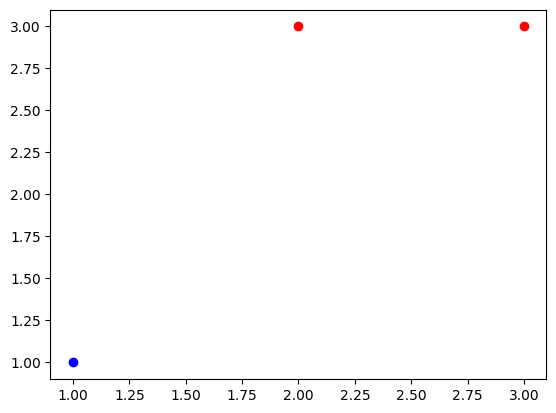

<Figure size 640x480 with 0 Axes>

In [195]:
plt.scatter(X[0, 0], X[0, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()
plt.clf()

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

In [196]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

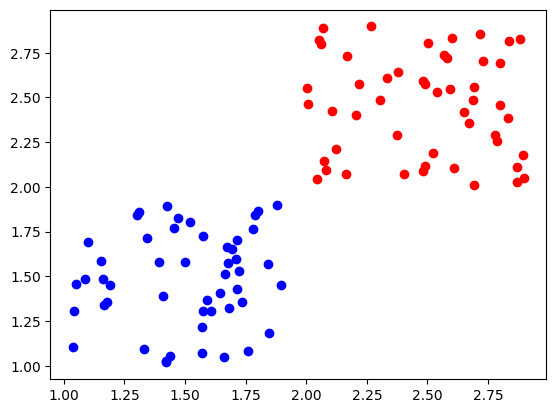

<Figure size 640x480 with 0 Axes>

In [197]:
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

In [198]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

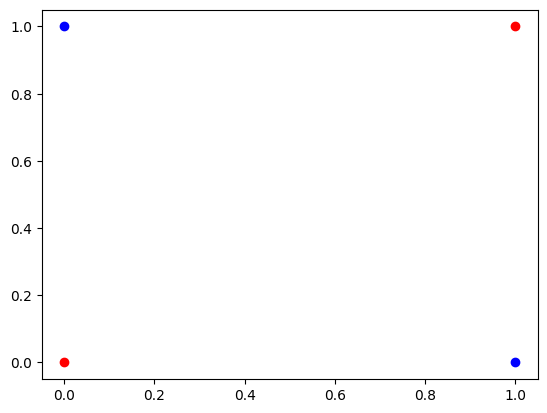

<Figure size 640x480 with 0 Axes>

In [199]:
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

In [200]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

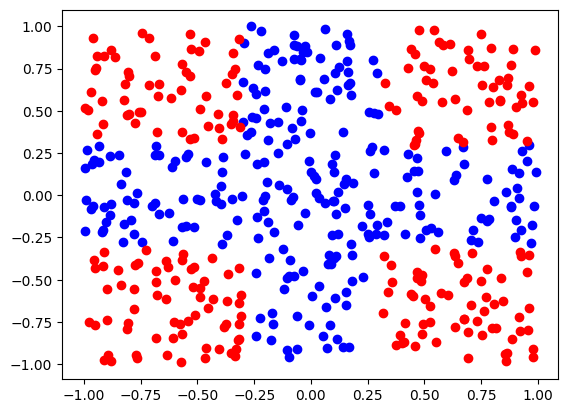

<Figure size 640x480 with 0 Axes>

In [201]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

In [202]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [-1, -1, -1]for p in X])

X = X[[not np.all(arr == [-1, -1, -1]) for arr in Y]]
Y = Y[[not np.all(arr == [-1, -1, -1]) for arr in Y]]

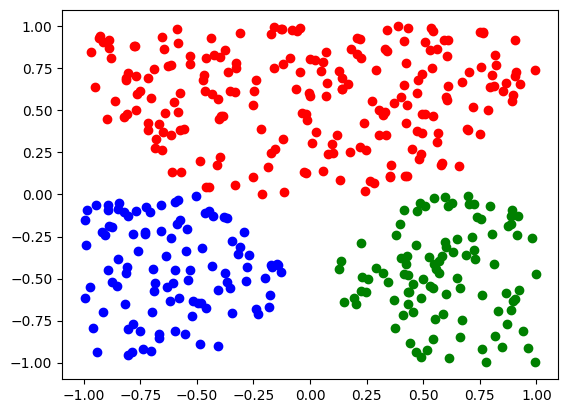

<Figure size 640x480 with 0 Axes>

In [203]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK

In [204]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [-1, -1, 1] for p in X])

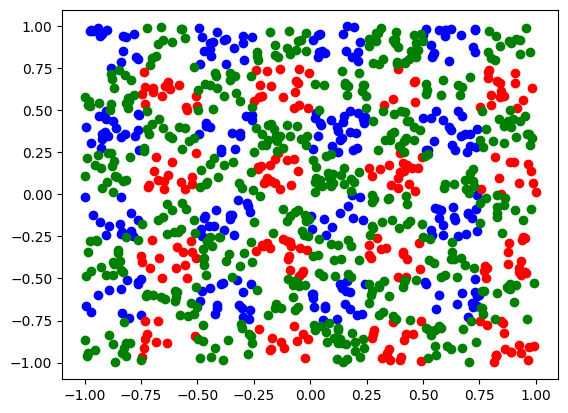

<Figure size 640x480 with 0 Axes>

In [205]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

In [206]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

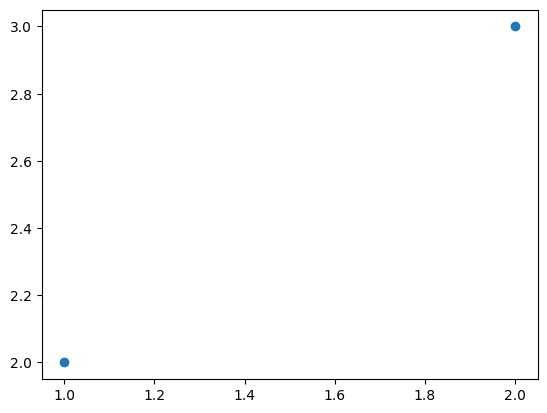

<Figure size 640x480 with 0 Axes>

In [207]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

In [208]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

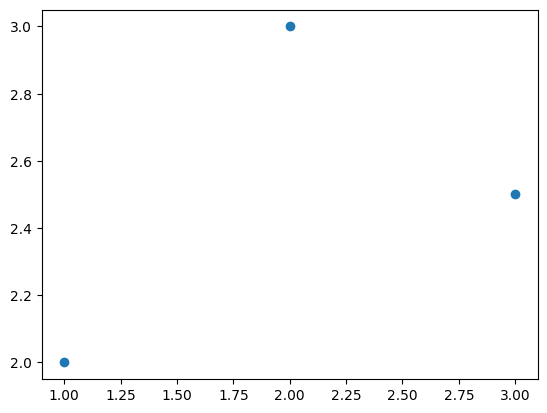

<Figure size 640x480 with 0 Axes>

In [209]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [210]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

In [211]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [212]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      1,
      2,
      3
])

In [213]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [214]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

In [215]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>